In [1]:
import os
from pathlib import Path
import numpy as np
import cv2
%pylab inline

import lib.orientation as orient
from lib.camera import img_from_device, denormalize, view_frame_from_device_frame, FULL_FRAME_SIZE

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from utils.paths import get_local_path

## Using the comma library to display the driven path 

In [3]:
example_segment = Path("/home/martin/datasets/comma2k19/processed_dataset/2018-06-18--21-20-21")

(288, 384, 3)
uint8
255
0
(60, 3)


Text(0.5, 1.0, 'Driven path projected onto first image')

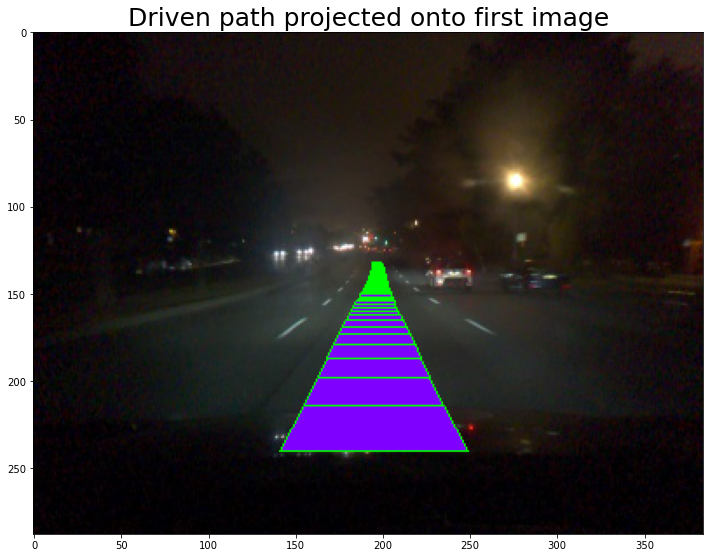

In [4]:
# We can project the path driven onto the first image
frame_times = np.load(example_segment / 'frame_times.npy')
frame_positions = np.load(example_segment / 'frame_positions.npy')
frame_orientations = np.load(example_segment / 'frame_orientations.npy')

# first we convert the frame_positions to the frame
# defined by the pose of the first frame
ecef_from_local = orient.rot_from_quat(frame_orientations[0])
local_from_ecef = ecef_from_local.T
frame_positions_local = np.einsum('ij,kj->ki', local_from_ecef, frame_positions - frame_positions[0])

def draw_path(device_path, img, width=0.5, height=1, fill_color=(128,0,255), line_color=(0,255,0)):
    device_path_l = device_path + np.array([0, 0, height])                                                                    
    device_path_r = device_path + np.array([0, 0, height])                                                                    
    device_path_l[:,1] -= width                                                                                               
    device_path_r[:,1] += width

    img_points_norm_l = img_from_device(device_path_l)
    img_points_norm_r = img_from_device(device_path_r)
    img_pts_l = denormalize(img_points_norm_l)
    img_pts_r = denormalize(img_points_norm_r)

    # filter out things rejected along the way
    valid = np.logical_and(np.isfinite(img_pts_l).all(axis=1), np.isfinite(img_pts_r).all(axis=1))
    img_pts_l = img_pts_l[valid].astype(int)
    img_pts_r = img_pts_r[valid].astype(int)

    for i in range(1, len(img_pts_l)):
        # Scale image points from original image size to current size
        w1, h1 = FULL_FRAME_SIZE
        h2, w2, _ = img.shape
        u1, v1 = img_pts_l[i-1]
        u2, v2 = img_pts_r[i-1]
        u3, v3 = img_pts_l[i]
        u4, v4 = img_pts_r[i]
        pts = np.array([[u1, v1], [u2, v2], [u4, v4], [u3, v3]], np.float64)
        pts[:, 0] *= w2/w1
        pts[:, 1] *= h2/h1
        pts = pts.astype(np.int32).reshape((-1, 1, 2))
        cv2.fillPoly(img, [pts], fill_color)
        cv2.polylines(img, [pts], True, line_color)

img = imread(str(example_segment / 'images/000000.jpg'))
print(img.shape)
print(img.dtype)
print(np.amax(img))
print(np.amin(img))
print(frame_positions_local[1:61].shape)
# Invert the path for hflip:
# frame_positions_local[:, 1] *= -1
draw_path(frame_positions_local[1:61], img) # show next 3 seconds (60 frames)
figsize(12,12);
imshow(img)
title('Driven path projected onto first image', fontsize=25)

In [5]:
frame_positions_local[1:61] # (n, 3) where cols are x,y,z
# These are the coordinates of the path in 3D space relative to the reference frame
# x is the axis along the length of the car
# y is the axis along the width of the car
# z is the axis along the height of the car

array([[ 9.27997667e-01,  1.01001690e-02, -3.37995244e-02],
       [ 1.85539975e+00,  2.12344629e-02, -6.65988295e-02],
       [ 2.78258594e+00,  3.31365311e-02, -9.85189894e-02],
       [ 3.70877663e+00,  4.53623543e-02, -1.29593342e-01],
       [ 4.63500645e+00,  5.80162545e-02, -1.60817432e-01],
       [ 5.56052465e+00,  7.14135600e-02, -1.92475327e-01],
       [ 6.48644916e+00,  8.47768854e-02, -2.24600395e-01],
       [ 7.41161219e+00,  9.92127675e-02, -2.57622120e-01],
       [ 8.33645895e+00,  1.14053867e-01, -2.91427698e-01],
       [ 9.26133481e+00,  1.28939359e-01, -3.25581059e-01],
       [ 1.01863209e+01,  1.44702992e-01, -3.59288492e-01],
       [ 1.11117232e+01,  1.60091542e-01, -3.92143127e-01],
       [ 1.20372530e+01,  1.75603479e-01, -4.24775262e-01],
       [ 1.29624162e+01,  1.92382250e-01, -4.57654375e-01],
       [ 1.38868227e+01,  2.09173312e-01, -4.91131527e-01],
       [ 1.48114445e+01,  2.26809368e-01, -5.25875209e-01],
       [ 1.57359667e+01,  2.46026050e-01

## Finding the fps of the data stream

In [6]:
frame_times.shape

(29999,)

In [7]:
frame_times

array([45196.065219, 45196.115224, 45196.165219, ..., 47235.886561,
       47235.936554, 47235.986557])

In [15]:
frame_lens = np.diff(frame_times)
print(frame_lens) # Each frame is ~0.05 seconds apart (20 fps)
frame_len = 0.05
print(1/frame_len)
n = 2
print(n/frame_len) # Number of frames needed for n seconds

[0.050005 0.049995 0.050007 ... 0.050008 0.049993 0.050003]
20.0
40.0


## Loading in the processed dataset and getting the driven path

In [17]:
dataset_path = Path("/home/martin/datasets/comma2k19/processed_dataset")

In [18]:
segment_path = dataset_path / '2018-09-19--14-14-47'
for file in segment_path.glob('*'):
    print(file)

/home/martin/datasets/comma2k19/processed_dataset/2018-09-19--14-14-47/frame_orientations.npy
/home/martin/datasets/comma2k19/processed_dataset/2018-09-19--14-14-47/frame_positions.npy
/home/martin/datasets/comma2k19/processed_dataset/2018-09-19--14-14-47/CAN_speeds.npy
/home/martin/datasets/comma2k19/processed_dataset/2018-09-19--14-14-47/images
/home/martin/datasets/comma2k19/processed_dataset/2018-09-19--14-14-47/CAN_angles.npy
/home/martin/datasets/comma2k19/processed_dataset/2018-09-19--14-14-47/frame_times.npy
/home/martin/datasets/comma2k19/processed_dataset/2018-09-19--14-14-47/frame_velocities.npy


In [19]:
# Load in data for this segment
frame_times = np.load(segment_path / 'frame_times.npy')
steering_angles = np.load(segment_path / 'CAN_angles.npy')
frame_positions = np.load(segment_path / 'frame_positions.npy')
frame_orientations = np.load(segment_path / 'frame_orientations.npy')
frame_velocities = np.load(segment_path / 'frame_velocities.npy')
frame_speed = np.linalg.norm(frame_velocities, axis=1) # predict this during training

In [20]:
def get_local_path(positions, orientations, reference_idx):
    # Define the segment frame positions referenced at a desired frame
    ecef_from_local = orient.rot_from_quat(orientations[reference_idx])
    local_from_ecef = ecef_from_local.T
    positions_local = np.einsum('ij,kj->ki', local_from_ecef, positions - positions[reference_idx])
    return positions_local

Text(0.5, 1.0, 'Frame 2270')

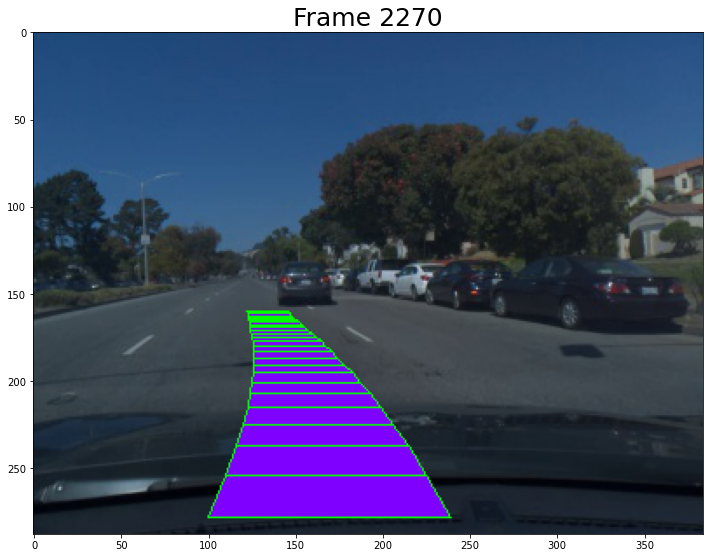

In [22]:
index = 2270
local_path = get_local_path(frame_positions, frame_orientations, index)
img_name = str(index).zfill(6) + '.jpg'
image = imread(str(segment_path / 'images' / img_name))
draw_path(local_path[index:index+30], image) # show 3 seconds
figsize(12,12);
imshow(image)
title(f"Frame {index}", fontsize=25)